# Временные ряды 4. Построение и оценка модели
##                                                              Обучаем и предсказываем

## Домашнее задание 4 

#### Задание

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .
3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек. 
5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)

6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

In [199]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

pd.options.display.max_columns = 100

In [200]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


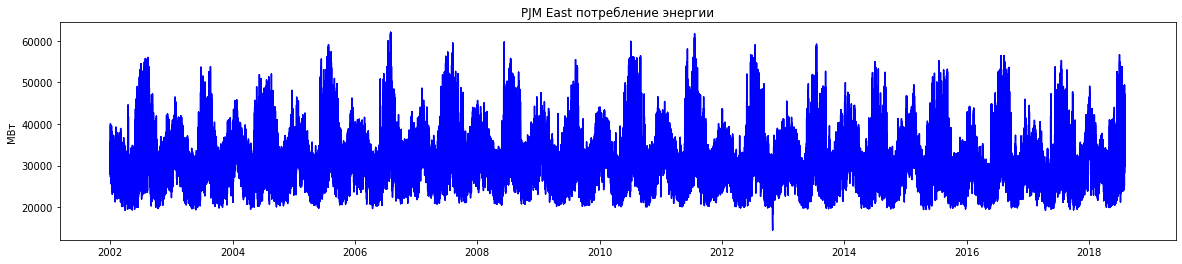

In [201]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Рис.1. Потребление энергии

### Методы машинного обучения для анализа рядов

Попробуем построить предсказание значений наших рядов на основании исследования отдельных примеров прошлого и различных параметров окружающих наши данные (календарь, макроэкономические показатели и т.п.). Основные типы обучаемых моделей можно разобрать на 2 группы :
- модель из одного решателя (линейная регрессия, нелинейная регрессия),
- ансамбль решателей (т.е. "коллектив" функций, который вычислит общее мнение). Это, например, модели типа адаптивного бустинга.
модели с одним решателем опираются на "опыт" единственного эксперта, который наблюдает явление и запоминает исходы при различных начальных условиях и в различные моменты времени. Ансамбли генерируют группу для совместной оценки, которая строит несколько решений одновременно и объединяет их в один ответ.

Привлекательность моделей предсказания значений временных рядов на основе обучения связана с тем, что нет необходимости проводить оценку сложности неизвестной на входе в задачу модели связывающей прогнозируемую величину с ее предшествующими значениями или другими временными рядами. Фактически можно взять все, что есть в наличии и заложить в обучаемую модель как входные переменные. Практически так делать не стоит, т.к. "плохие" признаки в обучаемой модели усложнят ее и приведут к неустойчивой работе в части рабочего диапазона. Таким образом схема решения задачи прогнозирования для временных рядов в обучаемых моделях принимает вполне привычный для машинного обучения вид:
- получить исходный ряд,
- определить список экзогенных факторов (внешних по отношению к прогнозируемому ряду), которые вероятно влияют на прогноз,
- определить глубину связей внутри ряда (ACF, PACF в помощь),
- преобразовать признаки - feature engenering,
- провести анализ признаков на важность и отделить важные - feature selection,
- построить первичный набор моделей и выбрать модель для тонкой настройки,
- подобрать гиперпараметры и провести обучение финальной модели,
- оценить качество модели и вернуться к предшествующим этапам при необходимости.

Следующий вопрос , который нужно решить, касается способа извлечения прогноза. Если мы следим за траекторией движения котенка, то у нас есть 2 варианта как определить его прогнозное положение через 1 минуту:

1 ) предсказывать прямо действия котенка через 1 минуту, т.е. построить решатель f(x(t), ..,x(t-p),y(t),..,y(t-p),t) = y(t+1),x(t+1), где x(t), ..,x(t-p),y(t),..,y(t-p) - координаты котенка в последние р моментов времени и t - текущий момент, t+1 момент наблюдений, который наступит через 1 минуту и , соответственно, прогнозные координаты y(t+1),x(t+1).

2 ) предсказывать f(x(t), ..,x(t-p),y(t),..,y(t-p),t) = y(t+dt),x(t+dt), т.е. предсказывать положение через dt<1 минуты, но проделать 1/dt циклов автопрогноза, опираясь на промежуточные y(t+dt),x(t+dt) , до достижения заданного горизонта прогнозирования.

**Спрашивается, какая тактика приносит успех?** Понятно, что чем дальше прогнозируемая точка, тем больше ошибка прогноза. Если мы попробуем предсказать, где будет котенок через 10 минут, вероятность угадать может быть близкой к 0. С другой стороны, если поведение объекта циклично, то наши шансы на успех значительно вырастут. Поэтапное прогнозирование на небольшом промежутке предсказания, хотя бы сначала, будет давать лучшее решение, т.к. короче интервал прогноза. Однако попадание в точку желаемого горизонта прогноза потребует применить f(x(t), ..,x(t-p),y(t),..,y(t-p),t) = y(t+dt),x(t+dt) 1/dt раз, что приводит к потере времени и накоплению ошибок.

Таким образом, следует обратиться к содержанию задачи прогнозирования и определить, уровень допустимой ошибки и что важнее в конкретных условиях: непрерывность решения (вариант 2) или получение конкретной точки (вариант генерации прогноза 1).

Рассмотрим построение модели прогнозирования точек ряда для наших рабочих примеров.


In [202]:
data_w = data.resample('W').mean()
data_w.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000


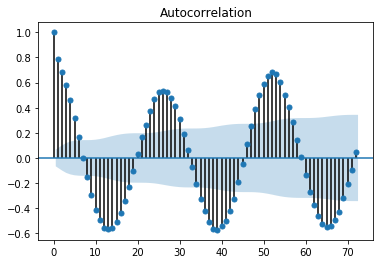

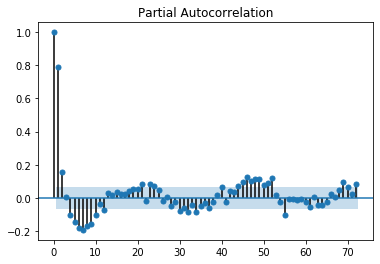

In [203]:
import statsmodels.api as sm
#plt.figure(figsize=(20,8))
#plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(data_w['PJME_MW'].values, lags=24*3)
plt.show()

#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(data_w['PJME_MW'].values, lags=24*3)
plt.show()

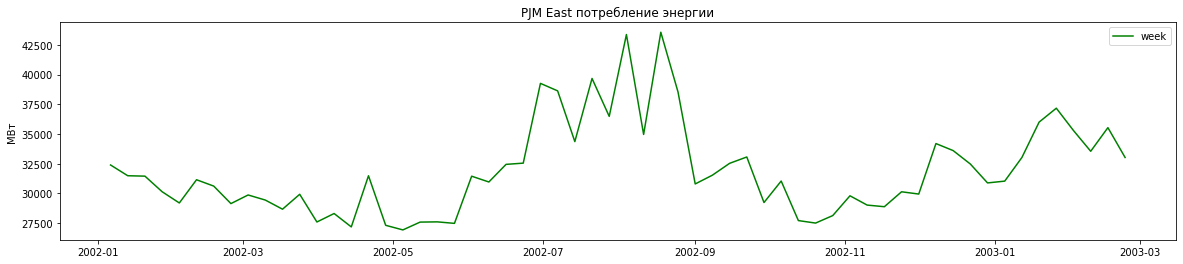

In [204]:
plt.figure(figsize =(20,4))
plt.plot( data_w.index[:5*4*3], data_w['PJME_MW'].values[:5*4*3], 'g',label='week'  )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.legend()
plt.show()

Удалим данные о часах и днях, т.к. они потеряли актуальность

In [205]:
data_w.drop(['hour', 'dayofmonth', 'dayofyear', 'dayofweek', 'is_holiday', 'is_prev_holiday', 'is_next_holiday'], axis=1,inplace=True)
data_w.head()

,PJME_MW,year,month,quarter,weekofyear
Date,,,,,
2002-01-06,32392.160839,2002.0,1.000000,1.0,1.0
2002-01-13,31487.386905,2002.0,1.000000,1.0,2.0
2002-01-20,31452.880952,2002.0,1.000000,1.0,3.0
2002-01-27,30141.529762,2002.0,1.000000,1.0,4.0
2002-02-03,29196.488095,2002.0,1.428571,1.0,5.0


In [206]:
data_w.drop('year', axis=1,inplace=True)

In [207]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE 
import seaborn as sns

scl=StandardScaler()
tsne_ =TSNE(n_components=2)

X = data_w.iloc[:,:-1].values

Xscale = scl.fit_transform(X)
X_t = tsne_.fit_transform(Xscale)

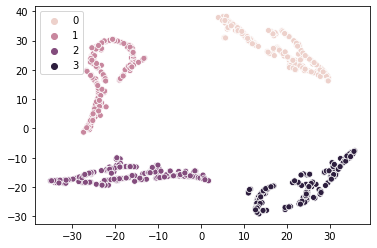

In [208]:
clast_0 = DBSCAN(eps=5, leaf_size=15 )
clast_1 = DBSCAN(eps=2, leaf_size=5)
X_clast =clast_0.fit_predict(X_t)
X_scale_clast =clast_1.fit_predict(Xscale)

sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_clast)
plt.show()

Рис.3. Результат кластер-анализа признаков

In [209]:
print('Число кластеров в календаре с масштабированием: ',len(np.unique(X_scale_clast)))
print('Число кластеров в календаре: ',len(np.unique(X_clast)))

Число кластеров в календаре с масштабированием:  1
Число кластеров в календаре:  4


Вариант кластеризации с разметкой на рис.3 для случая масштабированных координат показывает отлично выделяемые кластеры с хорошим размещением объектов по группам. Принадлежность кластерам можно использовать в качестве нового признака и проверить качество обработки модели с новой координатой. В данном конкретном примере кластеризация без масштабирования, но с понижением размерности выглядит очень обосновано. Берем этот вариант за основу и добавим признак к общему описанию задачи. 

In [210]:
data_w['week_month'] = X_clast
data_w.iloc[np.where(data_w['week_month']==0)[0]].iloc[:5,:]

,PJME_MW,month,quarter,weekofyear,week_month
Date,,,,,
2002-01-06,32392.160839,1.000000,1.0,1.0,0
2002-01-13,31487.386905,1.000000,1.0,2.0,0
2002-01-20,31452.880952,1.000000,1.0,3.0,0
2002-01-27,30141.529762,1.000000,1.0,4.0,0
2002-02-03,29196.488095,1.428571,1.0,5.0,0


In [211]:
data_w.iloc[np.where(data_w['week_month']==3)[0]].iloc[:5,:]

,PJME_MW,month,quarter,weekofyear,week_month
Date,,,,,
2002-10-06,31042.369048,9.857143,3.857143,40.0,3
2002-10-13,27714.601190,10.000000,4.000000,41.0,3
2002-10-20,27504.827381,10.000000,4.000000,42.0,3
2002-10-27,28137.335329,10.000000,4.000000,43.0,3
2002-11-03,29799.845238,10.428571,4.000000,44.0,3


Другой путь получения новых признаков применение преобразований для понижения размерности. Пример такого преобразования приведен выще в процессе построения признака из кластерного анализа , использовали редукцию пространства с использованием модели t-SNE. Однако, эта модель характерна высокой вычислительной сложностью, что увеличивает время решения задачи. Более простая, хотя и линейная модель, это PCA - метод главных компонент. Поскольку наши координаты календаря вполне связаны, то можно проверить и такой путь объединения признаков. Добавим признак на основе компонетного анализа. Построим 2 компоненты по признакам из календаря , без значений ряда и допишем их в общую таблицу data_d.

In [212]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')
Xpca=pca.fit_transform(Xscale[:,1:])
Xpca.shape

(866, 2)

In [213]:
data_w['pca1']=Xpca[:,0]
data_w['pca2']=Xpca[:,1]

Добавим новых признаков, описывающих содержание ряда. К таким признакам можно отнести разности ряда и разнообразные варианты сглаживания. Добавим к нашей модели 1-е разности. При этом следует помнить, что такие операции уменьшают общую длину корректной выборки на 1, т.е. первую строку данных следует исключить из модели в момент обучения.

In [214]:
first_diff =np.array(data_w.iloc[1:,0].values - data_w.iloc[:-1,0].values).astype('float32') 
data_w['diff1'] = 0
data_w['diff1'] =  data_w['diff1'].astype('float') 
data_w['diff1'].values[1:] = first_diff

Вообще можно добавить все, что можем придумать. Например, логарифм признака, частные признаков , частные логарифмов и т.д. 

In [215]:
first_diff_w =(first_diff) / data_w.iloc[1:,0].values
data_w['diff1_d'] = 0
data_w['diff1_d'] =  data_w['diff1_d'].astype('float') 
data_w['diff1_d'].values[1:] = np.array(first_diff_w).astype('float32')

In [216]:
first_diff_l =np.log(data_w.iloc[1:,0].values) 
data_w['diff1_l'] = 0
data_w['diff1_l'] =  data_w['diff1_l'].astype('float') 
data_w['diff1_l'].values[1:] = first_diff_l

А теперь добавим еще и экспонентциальную среднюю. Медленную, т.к. интересная информация лежит на уровне сезонных колебаний цены.

In [217]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

data_w['exp_0_05'] = exponential_smoothing(data_w['PJME_MW'], 0.05)


В итоге данные примут вид 

In [218]:
data_w.iloc[10:15,:]

,PJME_MW,month,quarter,weekofyear,week_month,pca1,pca2,diff1,diff1_d,diff1_l,exp_0_05
Date,,,,,,,,,,,
2002-03-17,28672.779762,3.0,1.0,11.0,0,-1.673114,0.235380,-768.130981,-0.026790,10.263704,31436.852496
2002-03-24,29927.488095,3.0,1.0,12.0,0,-1.673114,0.235380,1254.708374,0.041925,10.306533,31361.384276
2002-03-31,27595.869048,3.0,1.0,13.0,0,-1.673114,0.235380,-2331.619141,-0.084492,10.225421,31173.108514
2002-04-07,28308.778443,4.0,2.0,14.0,1,-0.819615,-0.199615,712.909424,0.025183,10.250927,31029.892011
2002-04-14,27182.482143,4.0,2.0,15.0,1,-0.819615,-0.199615,-1126.296265,-0.041435,10.210328,30837.521517


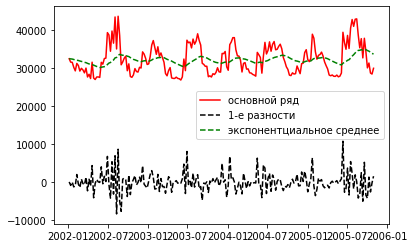

In [219]:
N100=200
plt.plot(data_w.index[:N100],data_w['PJME_MW'][:N100],'r',label ='основной ряд')
plt.plot(data_w.index[:N100],data_w['diff1'][:N100],'--k',label ='1-е разности')
plt.plot(data_w.index[:N100],data_w['exp_0_05'][:N100],'--g',label ='экспонентциальное среднее')
plt.legend()
plt.show()


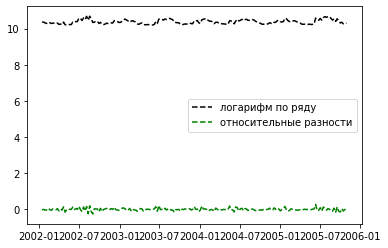

In [220]:
N100=200
plt.plot(data_w.index[1:N100],data_w['diff1_l'][1:N100],'--k',label ='логарифм по ряду')

plt.plot(data_w.index[1:N100],data_w['diff1_d'][1:N100],'--g',label ='относительные разности')
plt.legend()
plt.show()

Проблема состоит в том, что подобных признаков можно построить бесконечное количество. Для определения разумных интервалов имеет смысл вспомнить результаты анализа ряда в статистических моделях. Период сезонных колебаний 13 недель и недельный цикл по дням. Это позволит не строить все возможные сочетания параметров модели, а сократить их число до относительно небольшого подмножества. Посмотрим на примере экспоненциальных средних в диапазоне alpha = [0.3, 0.8] 

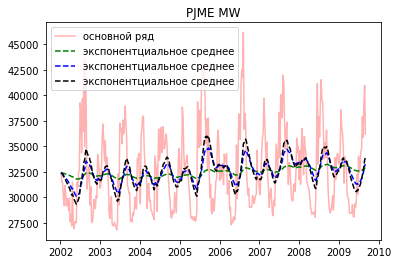

In [221]:
data_w['exp_0_01'] = exponential_smoothing(data_w['PJME_MW'], 0.01)
data_w['exp_0_03'] = exponential_smoothing(data_w['PJME_MW'], 0.03)
data_w['exp_0_04'] = exponential_smoothing(data_w['PJME_MW'], 0.04)
data_w['exp_0_06'] = exponential_smoothing(data_w['PJME_MW'], 0.06)
data_w['exp_0_07'] = exponential_smoothing(data_w['PJME_MW'], 0.07)
data_w['exp_0_08'] = exponential_smoothing(data_w['PJME_MW'], 0.08)

N100=400
plt.plot(data_w.index[:N100],data_w['PJME_MW'][:N100],'r',label ='основной ряд',alpha=0.3)
plt.plot(data_w.index[:N100],data_w['exp_0_01'][:N100],'--g',label ='экспонентциальное среднее')
plt.plot(data_w.index[:N100],data_w['exp_0_05'][:N100],'--b',label ='экспонентциальное среднее')
plt.plot(data_w.index[:N100],data_w['exp_0_08'][:N100],'--k',label ='экспонентциальное среднее')
plt.legend()
plt.title('PJME MW')
plt.show()

In [222]:
data_w.iloc[:7,14]=0

Добавим истории длиной p в признаках автокорреляции

In [223]:
p = 4
for i in range(p):
    data_w['t'+str(p-i)]=0
    data_w['t'+str(p-i)].values[p:] = data_w['PJME_MW'].values[i:-(p)+i]

Аналогично добавляем первые разности на глубину p

In [224]:
p = 4
for i in range(p):
    data_w['d'+str(p-i)]=0
    data_w['d'+str(p-i)].values[p:] = data_w['diff1'].values[i:-(p)+i]

Итоговая система признаков

In [225]:
data_w.head(10)

,PJME_MW,month,quarter,weekofyear,week_month,pca1,pca2,diff1,diff1_d,diff1_l,exp_0_05,exp_0_01,exp_0_03,exp_0_04,exp_0_06,exp_0_07,exp_0_08,t4,t3,t2,t1,d4,d3,d2,d1
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2002-01-06,32392.160839,1.000000,1.0,1.0,0,-2.091617,-0.183124,0.000000,0.000000,0.000000,32392.160839,32392.160839,32392.160839,32392.160839,0.000000,32392.160839,32392.160839,0,0,0,0,0,0,0,0
2002-01-13,31487.386905,1.000000,1.0,2.0,0,-2.091617,-0.183124,-904.773926,-0.028734,10.357342,32346.922142,32383.113100,32365.017621,32355.969882,0.000000,32328.826664,32319.778924,0,0,0,0,0,0,0,0
2002-01-20,31452.880952,1.000000,1.0,3.0,0,-2.091617,-0.183124,-34.505951,-0.001097,10.356246,32302.220083,32373.810778,32337.653521,32319.846325,0.000000,32267.510464,32250.427087,0,0,0,0,0,0,0,0
2002-01-27,30141.529762,1.000000,1.0,4.0,0,-2.091617,-0.183124,-1311.351196,-0.043506,10.313659,32194.185567,32351.487968,32271.769808,32232.713662,0.000000,32118.691815,32081.715301,0,0,0,0,0,0,0,0
2002-02-03,29196.488095,1.428571,1.0,5.0,0,-2.001938,-0.093445,-945.041687,-0.032368,10.281804,32044.300693,32319.937969,32179.511357,32111.264639,0.000000,31914.137554,31850.897124,32392,31487,31452,30141,0,-904,-34,-1311
2002-02-10,31150.517857,2.000000,1.0,6.0,0,-1.882365,0.026128,1954.029785,0.062729,10.346586,31999.611551,32308.243768,32148.641552,32072.834768,0.000000,31860.684176,31794.866783,31487,31452,30141,29196,-904,-34,-1311,-945
2002-02-17,30616.565476,2.000000,1.0,7.0,0,-1.882365,0.026128,-533.952393,-0.017440,10.329296,31930.459248,32291.326985,32102.679270,32014.583996,0.000000,31773.595867,31700.602678,31452,30141,29196,31150,-34,-1311,-945,1954
2002-02-24,29144.130952,2.000000,1.0,8.0,0,-1.882365,0.026128,-1472.434570,-0.050523,10.280009,31791.142833,32259.855025,32013.922820,31899.765875,31687.810323,31589.533323,31496.084940,30141,29196,31150,30616,-1311,-945,1954,-533
2002-03-03,29869.011905,2.428571,1.0,9.0,0,-1.792686,0.115807,724.880981,0.024269,10.304577,31695.036287,32235.946594,31949.575493,31818.535716,31578.682418,31469.096823,31365.919097,29196,31150,30616,29144,-945,1954,-533,-1472


## Выделение существенных признаков

Запишем итоговую систему признаков и проведем ее анализ. Горизонт прогнозирования h = 1, тогда target = y(t+h)=y(t+1) 

In [226]:
scl_target=StandardScaler() 
# p = 4
h=4
target = data_w['PJME_MW'].values[h+p:].reshape((data_w.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

(858, 1)

Входной набор признаков берем из нашей таблицы. Необходимо помнить, что у нас есть интегральные признаки (для календаря), которые связаны с базовыми признаками. Обычно такие признаки рассматривают отдельно. Однако для эксперимента оставим все признаки для процедуры селекции.

In [227]:
scl_x=StandardScaler() 

X = data_w.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(858, 25)

In [228]:
X[:7,14]=0

Размеры выборок по строкам совпали. Мы взяли на h строк меньше для Х и на h значений позднее по target. Таким образом, входной набор данных сформирован.

Как и во всех задачах обучения, системах признаков не идеальна. Есть признаки хорошие, а есть признаки плохие. Применим механизмы  селекции признаков для нашей модели. 
Рассмотрим механизмы селекции специфичные для регрессий и доступные из scikit-learn. Это два основных способа селекции: 
- построим или применим метрику взвешивающую связь признака и целевого свойства,
- проведем предварительное обучение и проверим влиятельность признаков по результатам такого обучения.

Такое решение задачи селекции признаков поддерживается через SelectKBest (отбираем k лучших признаков), SelectPercentile (отбираем заданный процент признаков) и SelectFromModel, соответственно(https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection). Посмотрим на результаты оценки нашей системы признаков.

In [229]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X, y.ravel())
f_test /= np.max(f_test)
for i in range(X.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))


F-test=0.98,  I=0
F-test=0.02,  I=1
F-test=0.03,  I=2
F-test=0.02,  I=3
F-test=0.03,  I=4
F-test=0.03,  I=5
F-test=0.00,  I=6
F-test=0.18,  I=7
F-test=0.18,  I=8
F-test=1.00,  I=9
F-test=0.13,  I=10
F-test=0.01,  I=11
F-test=0.08,  I=12
F-test=0.11,  I=13
F-test=0.13,  I=14
F-test=0.12,  I=15
F-test=0.11,  I=16
F-test=0.09,  I=17
F-test=0.00,  I=18
F-test=0.10,  I=19
F-test=0.42,  I=20
F-test=0.19,  I=21
F-test=0.23,  I=22
F-test=0.25,  I=23
F-test=0.22,  I=24


In [230]:
sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

(858, 5)

In [231]:
column_names = data_w.columns[sfk.get_support()]
column_names

Index(['PJME_MW', 'diff1_l', 't1', 'd3', 'd2'], dtype='object')

In [232]:
X_new1[295:300,:]

array([[ 0.33345566,  0.39653672, -0.20377049,  0.44439189, -1.51589853],
       [ 0.29447007,  0.35807057,  0.33641365, -1.51596297, -0.86635294],
       [-0.11228268, -0.054346  ,  0.29723712, -0.86536145,  0.83278694],
       [-0.52278232, -0.49259229, -0.11009839,  0.83654059, -0.06159932],
       [-0.60635742, -0.58474359, -0.52094974, -0.0592996 , -0.63043674]])

Лучшее множество признаков отделено в X_new1. Проверим результат оценки признаков по процентному отбору и сохраним его в X_new2.

In [233]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(858, 3)

In [234]:
column_namesp = data_w.columns[sfp.get_support()]
column_namesp

Index(['PJME_MW', 'diff1_l', 't1'], dtype='object')

Наконец, третий вариант - применим выделение признаков через построение модели. Помним, что модель должна уметь выбрать подмножество признаков или вернуть коэффициент их влиятельности. Это ограничивает выбор моделей. Возьмем как оценшик GradientBoostingRegressor и построим новое пространство в X_new3

In [235]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(858, 5)

Сравним результаты:


In [236]:
[X_new1[10:15,:], X_new2[10:15,:],X_new3[10:15,:]]

[array([[-1.22463043, -1.30047421, -0.94109296,  0.48830944, -0.90593098],
        [-0.14573899, -0.08920457, -1.22386717, -0.90500384,  0.27481408],
        [-1.19092333, -1.25981047, -0.1434989 ,  0.27766068, -0.4383668 ],
        [-1.28807979, -1.37756698, -1.19021553, -0.43667957,  1.66780613],
        [-1.12315832, -1.17866176, -1.28740348,  1.67291721, -1.61833583]]),
 array([[-1.22463043, -1.30047421, -0.94109296],
        [-0.14573899, -0.08920457, -1.22386717],
        [-1.19092333, -1.25981047, -0.1434989 ],
        [-1.28807979, -1.37756698, -1.19021553],
        [-1.12315832, -1.17866176, -1.28740348]]),
 array([[-1.22463043, -0.75411458, -1.23952175, -1.30047421, -0.84879452],
        [-0.14573899, -0.68744479, -1.23952175, -0.08920457, -0.53334388],
        [-1.19092333, -0.620775  , -1.23952175, -1.25981047, -1.11950396],
        [-1.28807979, -0.55410521, -0.31941925, -1.37756698, -0.94028778],
        [-1.12315832, -0.48743542,  0.04862175, -1.17866176, -1.22331362]])]

In [237]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0  9 20 22 23]
Номера признаков лучших признаков по процентной форме:  [ 0  9 20]
Номера признаков для выбора по модели :  [ 0  3  6  9 17]


Пересечение выбора по отбору для модели и по количественным оценкам связи в признаке 0. Имеет смысл брать объединение выборов. Возьмем [0,6,12,14,15,22,23] признаки и перейдем к построению модели.

In [238]:
# list_par=[0,3,9,17,20,22,23]
list_par=[0,3,9,17,20]
X_new = X[:,list_par]
data_w.columns[list_par]

Index(['PJME_MW', 'weekofyear', 'diff1_l', 't4', 't1'], dtype='object')


## Разделение данных на тестовые и тренировочные 

Построение модели начинаем с выделения тестовой части нашего ряда. Напомним, что для временных рядов тест - непрерывная часть ряда не входившая в обучение (временные ряды 1). Будем отделять по индексу, который задаст дату разделения модели на тест и обучение.

In [239]:
# сделаем функцию
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

Для временного ряда "Потребление энергии" назначим датой разделения 1/06/2016

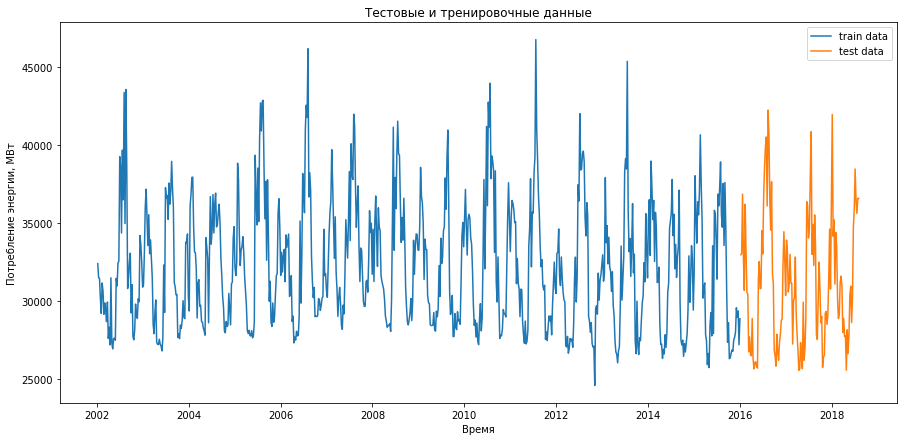

In [240]:
train, test = split_data( data_w, '01-06-2016')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [241]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [242]:
train.shape

(731, 25)

Выделим описание объекта и целевое свойство для тестовой и тренировочной частей ряда. Перейдем к построению моделей.  

# Строим Модель

При решении задачи на начальном этапе, самый интересный результат был получен на модели GradientBoostingRegressor. Остановимся на построении иенно такой формы предсказания. Импортируем необходимые модели.

In [243]:
from sklearn.ensemble import GradientBoostingRegressor

In [244]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)

Запускаем модели и смотрим , что они построят на наших примерах.

In [245]:
model_g.fit( X_train, y_train ) # 

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

**Посмотрим тесты**

In [246]:
X_test.shape

(127, 5)

In [247]:
y_test_pred_g = model_g.predict(X_test)

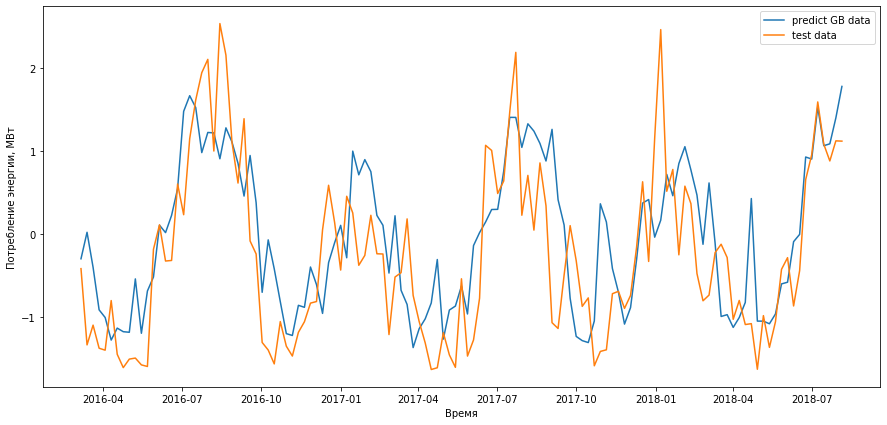

In [248]:

plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h+p:],y_test, label='test data')

plt.legend()
plt.show()

**Оценки для сравнения моделей**

Оценим промах модели, используя метрики, которые можно применять для оценки регрессий https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics:
- средне-квадратичное отклонение
- среднюю абсолютную ошибку
- коэфиициент детерминации 

In [249]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


In [250]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.574107454006002 
ошибка mae  :   0.5979885442406618 
оценка R2 :   0.46295487409850844


Абсолютная процентная ошибка (MAPE).Обратите внимание, что определять ее для масштабированной переменной не верно. Пожэтому переведем ответ решателя обратно в состояние без масштаба.

In [251]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [252]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   7.84409291008626 %


Ошибка неплоха, но мы имеем дело с маленьким горизонтом прогноза и тем неменее пока точность предсказания не превышает 93.5%. 
Построим более точную модель с использованием поиска моделей. Воспользуемся методом поиска 

In [253]:
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 2,1,4,5], 
              "n_estimators":[100,200,300,400,500]}

#  randomized search
n_iter_search = 10

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.645 (std: 0.050)
Parameters: {'n_estimators': 200, 'max_depth': 2}

Model with rank: 2
Mean validation score: 0.644 (std: 0.057)
Parameters: {'n_estimators': 500, 'max_depth': 1}

Model with rank: 3
Mean validation score: 0.628 (std: 0.060)
Parameters: {'n_estimators': 500, 'max_depth': 2}



Выбираем модель с рангом 3. {'n_estimators': 300, 'max_depth': 1} и проведем ее обучение на тренировочном наборе.

In [254]:
model_g_best = GradientBoostingRegressor(max_depth=2,  n_estimators=200)
model_g_best.fit( X_train, y_train ) 
y_test_pred_g = model_g_best.predict(X_test)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   7.226033463396576 %


# h=1

In [255]:
scl_target=StandardScaler() 
# p = 5
h=1
target = data_w['PJME_MW'].values[h+p:].reshape((data_w.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

(861, 1)

In [256]:
scl_x=StandardScaler() 

X = data_w.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(861, 25)

In [257]:
X[:7,14]=0

In [258]:
list_par=[0,3,9,17,20,22,23]
X_new = X[:,list_par]
data_w.columns[list_par]

Index(['PJME_MW', 'weekofyear', 'diff1_l', 't4', 't1', 'd3', 'd2'], dtype='object')

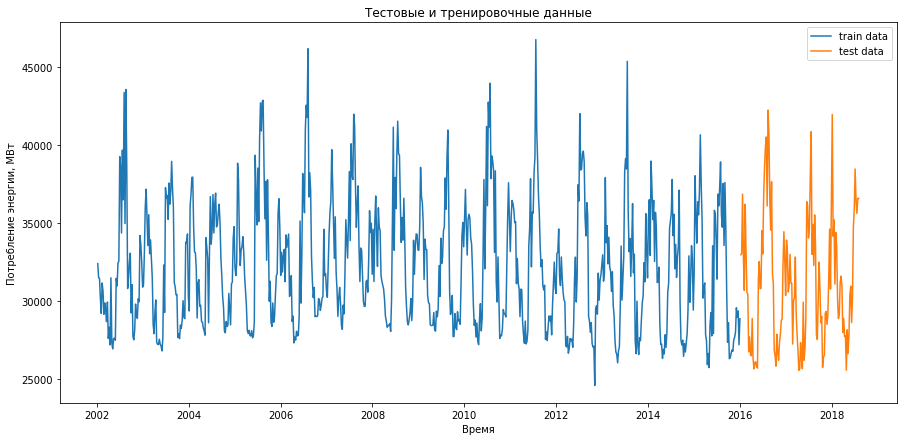

In [259]:
train, test = split_data( data_w, '01-06-2016')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [260]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [261]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)

In [262]:
model_g.fit( X_train, y_train )

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [263]:
y_test_pred_g = model_g.predict(X_test)

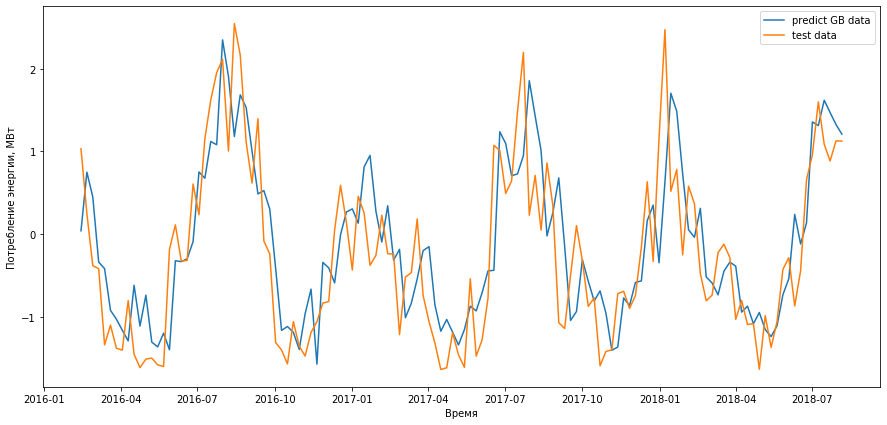

In [264]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h+p:],y_test, label='test data')

plt.legend()
plt.show()

In [265]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.432715736404644 
ошибка mae  :   0.5322568610024527 
оценка R2 :   0.5924428995496375


In [266]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   6.770220241125367 %


## Сохраниение модели

In [267]:
import pickle
# save the model to disk
filename = 'final_model.sav'
pickle.dump(model_g, open(filename, 'wb'))

filename = 'final_scaler_y.sav'
pickle.dump(scl_target, open(filename, 'wb'))

filename = 'final_scaler_x.sav'
pickle.dump(scl_x, open(filename, 'wb'))


## Использование модели для предсказания n*h моментов времени

Мы построили короткий прогноз, но его можно продолжить на следующие точки ряда. Для этого будем использовать результаты прогноза для следующего шага.  Необходимо заменять X_test[t+i, 0] = y_test[t+i-1] и продолжить моделирование в новом состоянии. Сделаем 10 недель прогноза.

In [268]:
# ['weekofyear', 'diff1_l', 't4', 't1']
def point_range(x1, x2):
    X_test_100 = X_test.copy()
    y_test_100 = y_test_pred_g.copy()
    N10 = 10
    for i in range(x1, x2):
        y_test_100[i] = model_g.predict(X_test_100[i,:].reshape((1,7)))
        # восстанавливаем не масштабированное значение ряда текущей точке  
        y_i=scl_target.inverse_transform(y_test_100[i:i+1]  )

        # заполняем вектор для прогноза следующей точки
        X_test_100[i+1,0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0]
        #'t4', 't1' автокорреляционные функции Признаки 2 и 3.
        X_test_100[i+1,2] = X_test_100[i-1,0]
        X_test_100[i+1,3] = X_test_100[i-4,0]
        #'d3', 'd2' автокорреляционные функции Признаки 2 и 3.
        #строим 'diff1_l' - признак под номером 1
        # строим логарифм по значению ряда и скалируем признак по схеме 15-го признака из основного списка
        xy_i=(np.log((y_i))-scl_x.mean_[9])*scl_x.scale_[9]
        #устанавливаем новое значение для 4
        X_test_100[i+1,1] = xy_i 
        
    er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test[x1:x2]),y_pred = scl_target.inverse_transform( y_test_100[x1:x2]))
    print(f'ошибка градиентного бустинга в диапазоне {x1} и {x2} от MAPE : {er_g} %')

In [269]:
for i in range (10, 90, 10):
    point_range(i, i+10)

ошибка градиентного бустинга в диапазоне 10 и 20 от MAPE : 11.549835565705246 %
ошибка градиентного бустинга в диапазоне 20 и 30 от MAPE : 9.363598261509436 %
ошибка градиентного бустинга в диапазоне 30 и 40 от MAPE : 29.218846855561992 %
ошибка градиентного бустинга в диапазоне 40 и 50 от MAPE : 6.6461245119694246 %
ошибка градиентного бустинга в диапазоне 50 и 60 от MAPE : 15.90142172034069 %
ошибка градиентного бустинга в диапазоне 60 и 70 от MAPE : 16.150106592555872 %
ошибка градиентного бустинга в диапазоне 70 и 80 от MAPE : 10.30846528217397 %
ошибка градиентного бустинга в диапазоне 80 и 90 от MAPE : 24.76348170077169 %


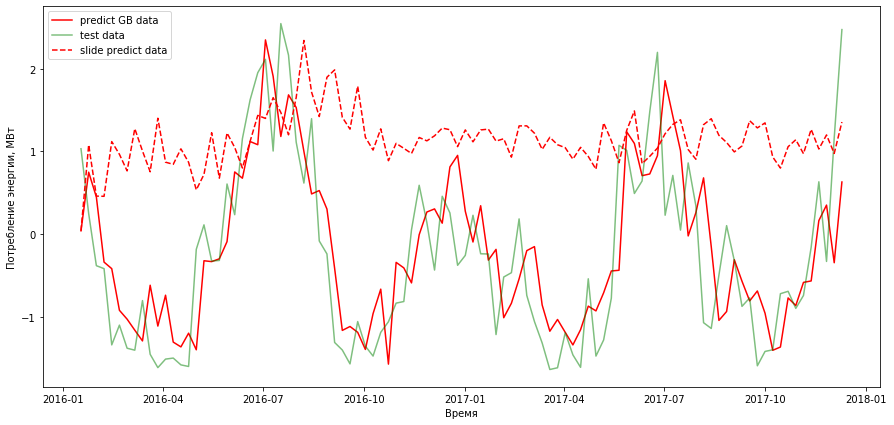

In [270]:
# ['weekofyear', 'diff1_l', 't4', 't1']
X_test_100 = X_test.copy()
y_test_100 = y_test_pred_g.copy()
N10 = 100
for i in range(N10):
    y_test_100[i] = model_g.predict(X_test_100[i,:].reshape((1,7)))
    # восстанавливаем не масштабированное значение ряда текущей точке  
    y_i=scl_target.inverse_transform(y_test_100[i:i+1]  )
                                     
    # заполняем вектор для прогноза следующей точки
    X_test_100[i+1,0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0]
    #'t4', 't1' автокорреляционные функции Признаки 2 и 3.
    X_test_100[i+1,2] = X_test_100[i-1,0]
    X_test_100[i+1,3] = X_test_100[i-4,0]
    #'d3', 'd2' автокорреляционные функции Признаки 2 и 3.
    #строим 'diff1_l' - признак под номером 1
    # строим логарифм по значению ряда и скалируем признак по схеме 15-го признака из основного списка
    xy_i=(np.log((y_i))-scl_x.mean_[9])*scl_x.scale_[9]
    #устанавливаем новое значение для 4
    X_test_100[i+1,1] = xy_i 
        
        
    
    
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N10+1],y_test_pred_g[:N10], 'r',label='predict GB data' )
plt.plot(test.index[1:N10+1],y_test[:N10], 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:N10+1],y_test_100[:N10], '--r',label='slide predict data')

plt.legend()
plt.show()    

### Вывод:
Ошибка меняется в зависимости от диапазона на который предсказывает модель. Это связанно с тем, что модель не учитывает тренд и в местах, где у модели и у временного ряда пики совпадают, ошибка минимальна.